### 线性回归 转 逻辑回归

In [39]:
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# 模拟数据
np.random.seed(42)
X = np.random.randn(1000, 2)  # 两个特征
y_continuous = X[:, 0] + 2 * X[:, 1] + np.random.randn(1000) * 0.1  # 线性回归目标
y_binary = (y_continuous > 0).astype(int)  # 逻辑回归目标（二分类）

# 拆分数据集
X_train, X_test, y_cont_train, y_cont_test = train_test_split(X, y_continuous, test_size=0.2, random_state=42)
y_bin_train, y_bin_test = train_test_split(y_binary, test_size=0.2, random_state=42)

# 步骤 1：训练线性回归模型
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_cont_train)
y_pred_cont_train = lin_reg.predict(X_train)  # 线性回归预测值（训练集）
y_pred_cont_test = lin_reg.predict(X_test)    # 线性回归预测值（测试集）

# 步骤 2：将线性回归预测值作为逻辑回归的特征
X_logistic_train = np.column_stack((X_train, y_pred_cont_train))  # 原始特征 + 线性回归预测
X_logistic_test = np.column_stack((X_test, y_pred_cont_test))

# 步骤 3：训练逻辑回归模型
log_reg = LogisticRegression()
log_reg.fit(X_logistic_train, y_bin_train)
y_pred_bin = log_reg.predict(X_logistic_test)

# 评估
accuracy = accuracy_score(y_bin_test, y_pred_bin)
print("逻辑回归准确率:", accuracy)

逻辑回归准确率: 0.975


### 手写逻辑回归

In [3]:
import numpy as np

from homemade.utils.features import prepare_for_training
from homemade.utils.hypothesis import sigmoid

class MlLogisticRegression():
    def __init__(self, data, labels, polynomial_degree=0, sinusoid_degree=0, normalize_data=False):
        (data_processed,
         features_mean,
         features_deviation) = prepare_for_training(data, polynomial_degree, sinusoid_degree, normalize_data)
        self.data = data_processed
        self.labels = labels
        self.polynomial_degree = polynomial_degree
        self.sinusoid_degree = sinusoid_degree
        self.normalize_data = normalize_data
        self.features_mean = features_mean
        self.features_deviation = features_deviation

        ## 特征列数
        self.num_features = self.data.shape[1]
        ## 样本个数
        self.num_samples = self.data.shape[0]

        ## 分类类别
        self.unique_labels = np.unique(self.labels)
        ## 分类个数
        self.num_unique_labels = len(self.unique_labels)

        ## 150 * 6  3类

        ## 初始化权重
        ## theta怎么定义
        ## 目标: 计算每个样本的属于各个类别的概率值
        ## 样本的维度(num_features, 特征列数)
        ## 样本:
        ## [
        ##  [x00, x01, x02 ..., x0n]
        ##  [x10, x11, x12 ..., x1n]
        ##  [x20, x21, x22 ..., x2n]
        ##  ...
        ##  [xm0, xm1, xm2 ..., xmn]
        ## ]
        ## 计算一个样本属于类别1的概率p1, 属于类别2的概率p2, 属于类别3的概率p3
        ## p0 = x00*t00+x01*t01+...+x0n*t0n
        ## p1 = x00*t10+x01*t11+...+x0n*t1n
        ## p2 = x00*t20+x01*t21+...+x0n*t2n
        ## 需要计算3个类别的概率, 所以, theta的行数 = 类别数
        ## 需要有n列个参数t,才能和样本特征列数匹配上,所以,theta的列数位样本特征数
        ## 所以theta的维度就是(num_features, 类别数)
        self.thetas = np.zeros((self.num_unique_labels, self.num_features))

    def train(self, lr = 0.01, max_iterations=500):
        cost_histories = []
        for label_index, label in enumerate(self.unique_labels):
            target = (self.labels == label).astype(float)
            label_theta = np.copy(self.thetas[label_index])
            new_theta, cost_history = MlLogisticRegression.gradient_descent(self.data, target, label_theta, lr, max_iterations)
            self.thetas[label_index] = new_theta
            cost_histories.append(cost_history)
        return self.thetas, cost_histories

    def predict(self, data):
        (data_processed,
         features_mean,
         features_deviation) = prepare_for_training(data, self.polynomial_degree, self.sinusoid_degree, self.normalize_data)
        probs = MlLogisticRegression.hypothesis(data_processed, self.thetas.T)
        return self.unique_labels[np.argmax(probs, axis=1)]

    @staticmethod
    def gradient_descent(data, target, label_theta, lr, max_iterations):
        cost_history = []
        new_theta = label_theta
        for iteration in range(max_iterations):
            ## 计算梯度,并根据学习率,更新梯度(即更新theta, 所谓的梯度下降)
            new_theta = MlLogisticRegression.gradient_step(data, target, lr, new_theta)
            ## 计算最新的权重theta的损失,并记录
            cost_history.append(MlLogisticRegression.cost_function(data, target, new_theta))
            if iteration > 1 and abs(cost_history[-1] - cost_history[-2]) < 1e-6:
                break
        return new_theta, cost_history

    def predict_proba(self, data):
        data_processed, _, _ = prepare_for_training(data, self.polynomial_degree, self.sinusoid_degree, self.normalize_data)
        return MlLogisticRegression.hypothesis(data_processed, self.thetas.T)


    @staticmethod
    def gradient_step(data, target, lr, theta):
        n = len(data)
        y_hat = MlLogisticRegression.hypothesis(data, theta)
        error = y_hat - target
        theta = theta - lr * (1/n) * (data.T @ error)
        return theta

    @staticmethod
    def cost_function(data, target, thetas):
        n = len(data)
        y_hat = MlLogisticRegression.hypothesis(data, thetas)
        cross_entropy = -1/n * (target.T @ np.log(y_hat) + (1 - target).T @ np.log(1 - y_hat))
        return cross_entropy

    @staticmethod
    def hypothesis(data, thetas):
        return np.clip(sigmoid(data @ thetas), 1e-8, 1 - 1e-8)


In [4]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
iris_data = load_iris(as_frame=True)
print(iris_data.feature_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [5]:
data = iris_data.data[['petal length (cm)', 'petal width (cm)']]
labels = np.array([iris_data.target_names[target] for target in iris_data.target])

data = np.array(data)
labels = np.array(labels)
print(data)
print(labels)

[[1.4 0.2]
 [1.4 0.2]
 [1.3 0.2]
 [1.5 0.2]
 [1.4 0.2]
 [1.7 0.4]
 [1.4 0.3]
 [1.5 0.2]
 [1.4 0.2]
 [1.5 0.1]
 [1.5 0.2]
 [1.6 0.2]
 [1.4 0.1]
 [1.1 0.1]
 [1.2 0.2]
 [1.5 0.4]
 [1.3 0.4]
 [1.4 0.3]
 [1.7 0.3]
 [1.5 0.3]
 [1.7 0.2]
 [1.5 0.4]
 [1.  0.2]
 [1.7 0.5]
 [1.9 0.2]
 [1.6 0.2]
 [1.6 0.4]
 [1.5 0.2]
 [1.4 0.2]
 [1.6 0.2]
 [1.6 0.2]
 [1.5 0.4]
 [1.5 0.1]
 [1.4 0.2]
 [1.5 0.2]
 [1.2 0.2]
 [1.3 0.2]
 [1.4 0.1]
 [1.3 0.2]
 [1.5 0.2]
 [1.3 0.3]
 [1.3 0.3]
 [1.3 0.2]
 [1.6 0.6]
 [1.9 0.4]
 [1.4 0.3]
 [1.6 0.2]
 [1.4 0.2]
 [1.5 0.2]
 [1.4 0.2]
 [4.7 1.4]
 [4.5 1.5]
 [4.9 1.5]
 [4.  1.3]
 [4.6 1.5]
 [4.5 1.3]
 [4.7 1.6]
 [3.3 1. ]
 [4.6 1.3]
 [3.9 1.4]
 [3.5 1. ]
 [4.2 1.5]
 [4.  1. ]
 [4.7 1.4]
 [3.6 1.3]
 [4.4 1.4]
 [4.5 1.5]
 [4.1 1. ]
 [4.5 1.5]
 [3.9 1.1]
 [4.8 1.8]
 [4.  1.3]
 [4.9 1.5]
 [4.7 1.2]
 [4.3 1.3]
 [4.4 1.4]
 [4.8 1.4]
 [5.  1.7]
 [4.5 1.5]
 [3.5 1. ]
 [3.8 1.1]
 [3.7 1. ]
 [3.9 1.2]
 [5.1 1.6]
 [4.5 1.5]
 [4.5 1.6]
 [4.7 1.5]
 [4.4 1.3]
 [4.1 1.3]
 [4.  1.3]
 [4.4 1.2]

(120, 2) (120,)


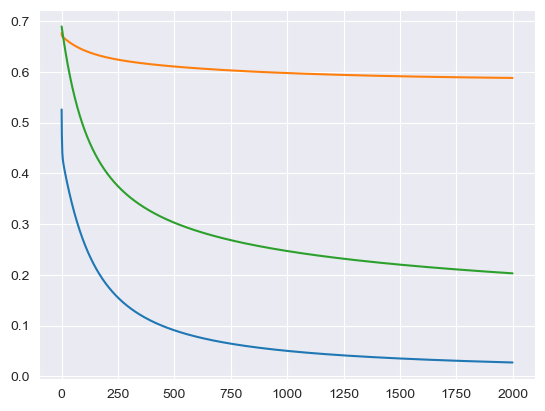

In [6]:
X_train, X_test, y_train, y_test, target_train, target_test = train_test_split(data, labels, iris_data.target, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
logist_reg = MlLogisticRegression(data=X_train, labels=y_train)
thetas, cost_histories = logist_reg.train(lr=0.1, max_iterations=2000)

index = 0
for history in cost_histories:
    plt.plot(history, label='cost type={}'.format(logist_reg.unique_labels[index]))
    index += 1
plt.show()

In [7]:
y_hat = logist_reg.predict(X_test)
accuracy = np.sum(y_test == y_hat) / len(y_test)
print('精确率', accuracy)

精确率 0.9666666666666667


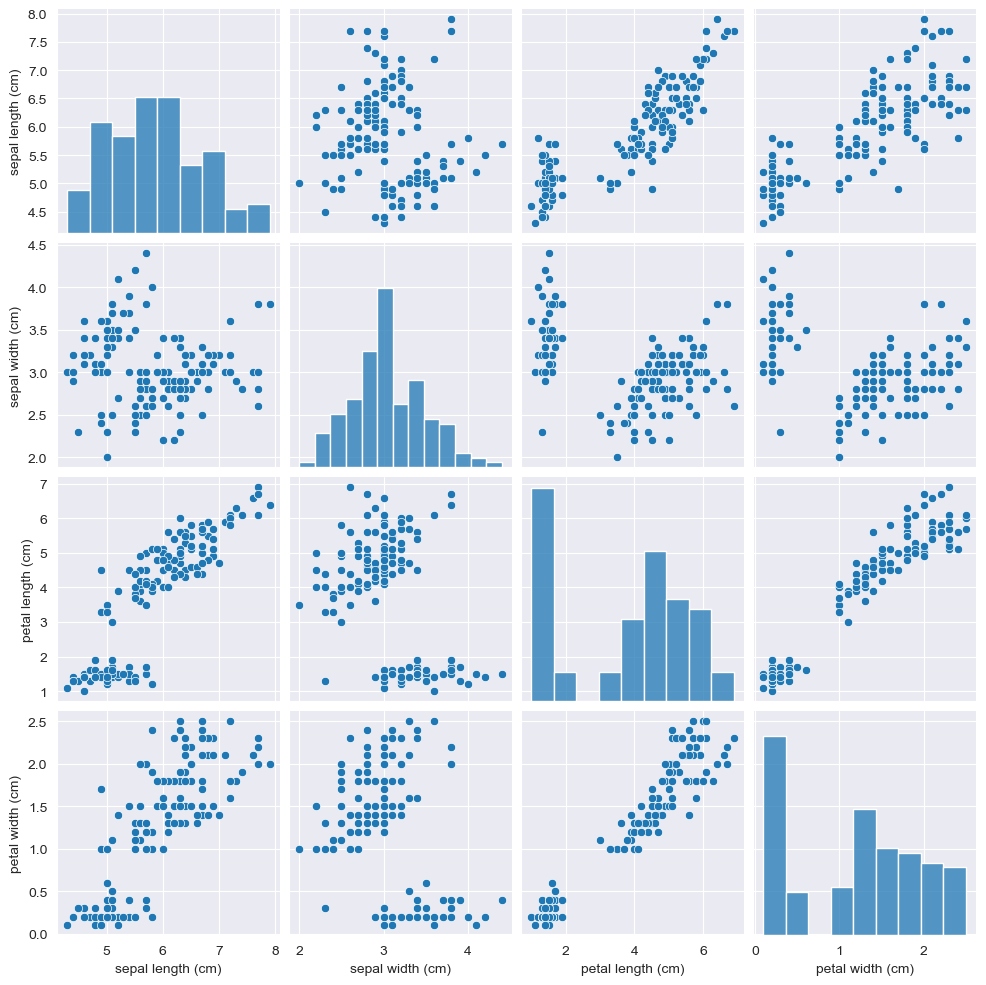

In [8]:
import seaborn as sns
sns.pairplot(data=iris_data.data)
plt.show()

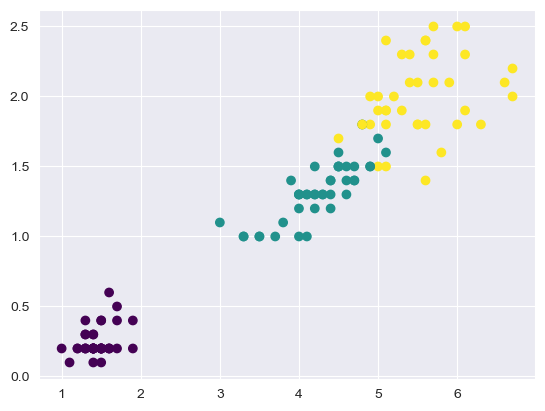

In [9]:
y_color = np.zeros(y_train.shape[0])
for i in range(len(y_train)):
    if y_train[i] == iris_data.target_names[0]:
        y_color[i] = 0
    elif y_train[i] == iris_data.target_names[1]:
        y_color[i] = 1
    elif y_train[i] == iris_data.target_names[2]:
        y_color[i] = 2

plt.scatter(X_train[:, 0], X_train[:, 1], c=target_train, cmap='viridis')
plt.show()

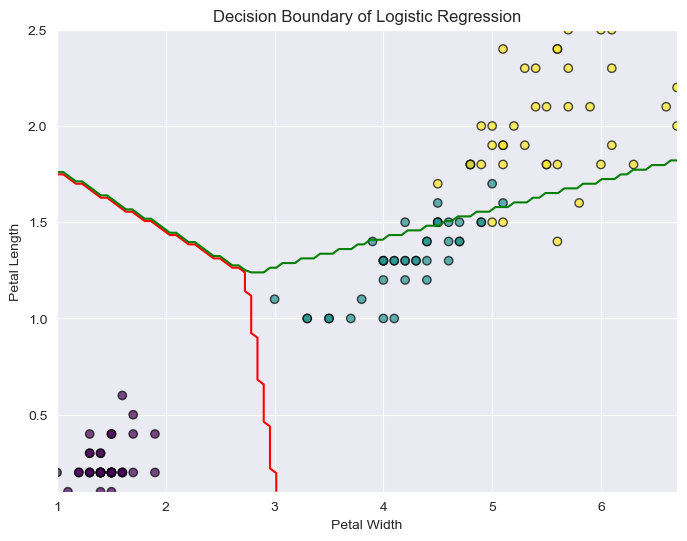

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# 构造网格
pw = np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 100)
pl = np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 100)
xx, yy = np.meshgrid(pw, pl)
grid = np.c_[xx.ravel(), yy.ravel()]

# 模型预测
z = logist_reg.predict(grid)

# 标签转换为整数索引
label_to_int = {label: i for i, label in enumerate(iris_data.target_names)}
zz = np.vectorize(label_to_int.get)(z).reshape(xx.shape)

# 绘图
plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=target_train, cmap='viridis', edgecolor='k', alpha=0.7)
plt.contour(xx, yy, zz, levels=[0, 1, 2], colors=["red", "green", "blue"])
plt.xlabel("Petal Width")
plt.ylabel("Petal Length")
plt.axis([pw.min(), pw.max(), pl.min(), pl.max()])
plt.title("Decision Boundary of Logistic Regression")
plt.show()


In [11]:
print(thetas)

[[ 6.03178547 -1.67749475 -2.58346253]
 [-2.28875574  1.03181669 -1.89614521]
 [-6.8629303   0.19718246  3.64457168]]


### 采用minimize写逻辑回归

In [12]:
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt

from homemade.utils.features import prepare_for_training
from homemade.utils.hypothesis import sigmoid

class LogisticRegression_with_minimize():
    def __init__(self, data, labels, polynomial_degree=0, sinusoid_degree=0, normalize_data=False):
        (data_processed,
         features_mean,
         features_deviation) = prepare_for_training(data, polynomial_degree, sinusoid_degree, normalize_data)
        self.data = data_processed
        self.labels = labels
        self.polynomial_degree = polynomial_degree
        self.sinusoid_degree = sinusoid_degree
        self.normalize_data = normalize_data
        self.features_mean = features_mean
        self.features_deviation = features_deviation

        ## 特征列数
        num_features = self.data.shape[1]
        ## 分类类别
        self.unique_labels = np.unique(self.labels)
        ## 分类个数
        num_unique_labels = len(self.unique_labels)
        self.thetas = np.zeros((num_unique_labels, num_features))

    def train(self, max_iterations=500):
        cost_histories = []

        for label_index, unique_label in enumerate(self.unique_labels):
            current_labels = (self.labels == unique_label).astype(float)
            current_initial_theta = np.copy(self.thetas[label_index])

            # Run gradient descent.
            (current_theta, cost_history) = LogisticRegression_with_minimize.gradient_descent(
                self.data,
                current_labels,
                current_initial_theta,
                max_iterations,
            )

            self.thetas[label_index] = current_theta.T
            cost_histories.append(cost_history)
        return self.thetas, cost_histories

    def predict_proba(self, data):
        (data_processed, _, _) = prepare_for_training(data, self.polynomial_degree, self.sinusoid_degree,
                                                      self.normalize_data)
        return LogisticRegression_with_minimize.hypothesis(data_processed, self.thetas.T)

    def predict(self, data):
        (data_processed,
         features_mean,
         features_deviation) = prepare_for_training(data, self.polynomial_degree, self.sinusoid_degree, self.normalize_data)
        probs = LogisticRegression_with_minimize.hypothesis(data_processed, self.thetas.T)
        num_examples = data.shape[0]
        return self.unique_labels[np.argmax(probs, axis=1)].reshape((num_examples, 1))

    @staticmethod
    def gradient_descent(data, labels, initial_theta, max_iterations):
        # cost_history = []
        # new_theta = label_theta
        # for iteration in range(max_iterations):
        #     ## 计算梯度,并根据学习率,更新梯度(即更新theta, 所谓的梯度下降)
        #     new_theta = MlLogisticRegression.gradient_step(data, target, lr, new_theta)
        #     ## 计算最新的权重theta的损失,并记录
        #     cost_history.append(MlLogisticRegression.cost_function(data, target, new_theta))
        # return new_theta, cost_history

        cost_history = []
        num_features = data.shape[1]
        minification_result = minimize(
            # Function that we're going to minimize.
            lambda current_theta: LogisticRegression_with_minimize.cost_function(
                data, labels, current_theta.reshape((num_features, 1))
            ),
            # Initial values of model parameter.
            initial_theta,
            # We will use conjugate gradient algorithm.
            method='CG',
            # Function that will help to calculate gradient direction on each step.
            jac=lambda current_theta: LogisticRegression_with_minimize.gradient_step(
                data, labels, current_theta.reshape((num_features, 1))
            ),
            # Record gradient descent progress for debugging.
            callback=lambda current_theta: cost_history.append(LogisticRegression_with_minimize.cost_function(
                data, labels, current_theta.reshape((num_features, 1))
            )),
            options={'maxiter': max_iterations}
        )
        # Reshape the final version of model parameters.
        optimized_theta = minification_result.x.reshape((num_features, 1))

        return optimized_theta, cost_history

    @staticmethod
    def gradient_step(data, labels, theta):
        num_examples = len(data)
        y_hat = LogisticRegression_with_minimize.hypothesis(data, theta)
        error = y_hat - labels
        gradients = (1/num_examples) * (data.T @ error)
        return gradients.T.flatten()

    @staticmethod
    def hypothesis(data, thetas):
        return np.clip(sigmoid(data @ thetas), 1e-8, 1 - 1e-8)

    @staticmethod
    def cost_function(data, labels, theta):
        num_examples = len(data)
        y_hat = LogisticRegression_with_minimize.hypothesis(data, theta)
        cross_entropy = -1/num_examples * (labels.T @ np.log(y_hat) + (1 - labels).T @ np.log(1 - y_hat))
        return cross_entropy[0][0]

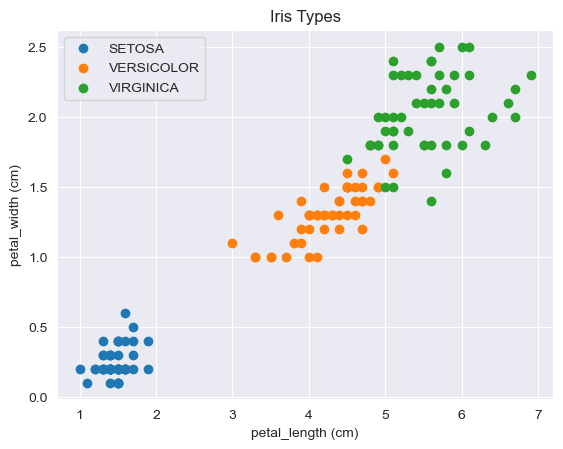

In [13]:
import pandas as pd
data = pd.read_csv('../../data/iris.csv')

# List of suppported Iris classes.
iris_types = ['SETOSA', 'VERSICOLOR', 'VIRGINICA']

# Pick the Iris parameters for consideration.
x_axis = 'petal_length'
y_axis = 'petal_width'

# Plot the scatter for every type of Iris.
for iris_type in iris_types:
    plt.scatter(
        data[x_axis][data['class'] == iris_type],
        data[y_axis][data['class'] == iris_type],
        label=iris_type
    )

# Plot the data.
plt.xlabel(x_axis + ' (cm)')
plt.ylabel(y_axis + ' (cm)')
plt.title('Iris Types')
plt.legend()
plt.show()

In [14]:
# Get total number of Iris examples.
num_examples = data.shape[0]

# Get features.
x_train = data[[x_axis, y_axis]].values.reshape((num_examples, 2))
# Get labels.
y_train = data['class'].values.reshape((num_examples, 1))

# Set up linear regression parameters.
max_iterations = 1000  # Max number of gradient descent iterations.
regularization_param = 0  # Helps to fight model overfitting.
polynomial_degree = 0  # The degree of additional polynomial features.
sinusoid_degree = 0  # The degree of sinusoid parameter multipliers of additional features.

# Init logistic regression instance.
logistic_regression = LogisticRegression_with_minimize(x_train, y_train, polynomial_degree, sinusoid_degree)

# Train logistic regression.
(thetas, costs) = logistic_regression.train(max_iterations=max_iterations)

# Print model parameters that have been learned.
res = pd.DataFrame(thetas, columns=['Theta 1', 'Theta 2', 'Theta 3'], index=['SETOSA', 'VERSICOLOR', 'VIRGINICA'])
print(res)

              Theta 1   Theta 2    Theta 3
SETOSA      30.289120 -8.403577 -12.312100
VERSICOLOR  -2.858904  1.546523  -3.107221
VIRGINICA  -45.465701  5.783991  10.476565


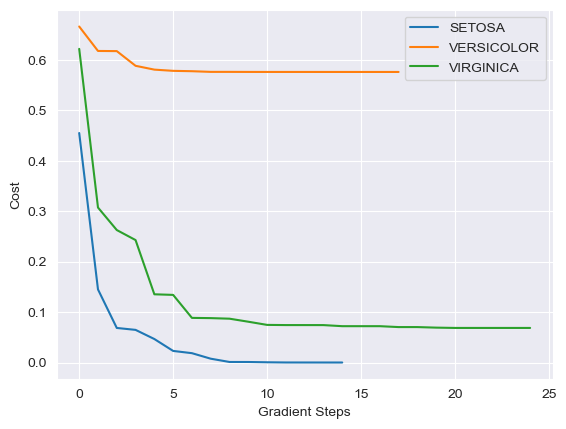

In [15]:
labels = logistic_regression.unique_labels
plt.plot(range(len(costs[0])), costs[0], label=labels[0])
plt.plot(range(len(costs[1])), costs[1], label=labels[1])
plt.plot(range(len(costs[2])), costs[2], label=labels[2])

plt.xlabel('Gradient Steps')
plt.ylabel('Cost')
plt.legend()
plt.show()

In [16]:
# Make training set predictions.
y_train_predictions = logistic_regression.predict(x_train)

# Check what percentage of them are actually correct.
precision = np.sum(y_train_predictions == y_train.ravel()) / y_train.shape[0] * 100

print('Precision: {:5.4f}%'.format(precision))

Precision: 5000.0000%


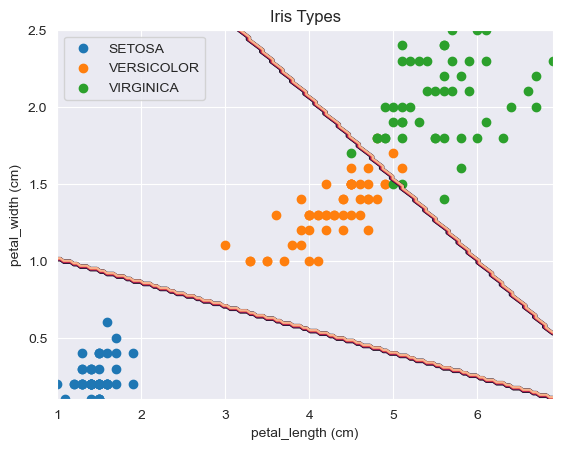

In [17]:
samples = 150

x_min = np.min(x_train[:, 0])
x_max = np.max(x_train[:, 0])

y_min = np.min(x_train[:, 1])
y_max = np.max(x_train[:, 1])

X = np.linspace(x_min, x_max, samples)
Y = np.linspace(y_min, y_max, samples)
Z_setosa = np.zeros((samples, samples))
Z_versicolor = np.zeros((samples, samples))
Z_virginica = np.zeros((samples, samples))

for x_index, x in enumerate(X):
    for y_index, y in enumerate(Y):
        data = np.array([[x, y]])
        prediction = logistic_regression.predict(data)[0][0]
        if prediction == 'SETOSA':
            Z_setosa[x_index][y_index] = 1
        elif prediction == 'VERSICOLOR':
            Z_versicolor[x_index][y_index] = 1
        elif prediction == 'VIRGINICA':
            Z_virginica[x_index][y_index] = 1

# Now, when we have x, y and z axes being setup and calculated we may print decision boundaries.
for iris_type in iris_types:
    plt.scatter(
        x_train[(y_train == iris_type).flatten(), 0],
        x_train[(y_train == iris_type).flatten(), 1],
        label=iris_type
    )

plt.contour(X, Y, Z_setosa)
plt.contour(X, Y, Z_versicolor)
plt.contour(X, Y, Z_virginica)

plt.xlabel(x_axis + ' (cm)')
plt.ylabel(y_axis + ' (cm)')
plt.title('Iris Types')
plt.legend()
plt.show()


### 非线性变换 逻辑回归

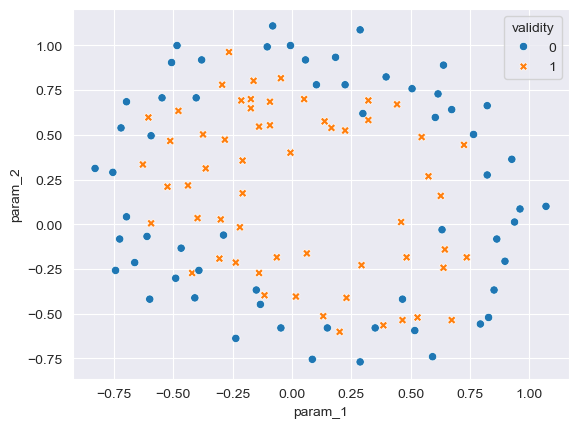

In [37]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math

data = pd.read_csv('../../data/microchips-tests.csv')
import seaborn as sns
sns.scatterplot(data, x='param_1', y='param_2', hue='validity', style='validity')
plt.show()

In [34]:
X_train = np.array(data[['param_1', 'param_2']])
y_train = np.array(data[['validity']])
lrwm = LogisticRegression_with_minimize(X_train, y_train, polynomial_degree=10, sinusoid_degree=8, normalize_data=False)
(thetas, cost_histories) = lrwm.train(max_iterations=100)

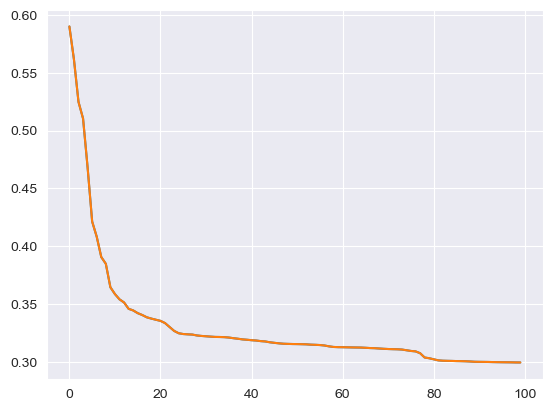

In [35]:
for cost_history in cost_histories:
    plt.plot(cost_history)
plt.show()

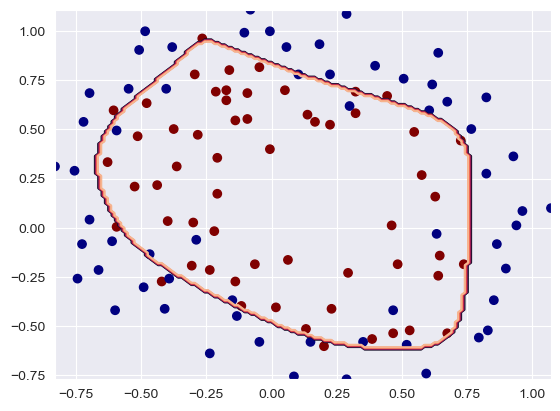

In [36]:
samples = 150

x_min = np.min(X_train[:, 0])
x_max = np.max(X_train[:, 0])

y_min = np.min(X_train[:, 1])
y_max = np.max(X_train[:, 1])

X = np.linspace(x_min, x_max, samples)
Y = np.linspace(y_min, y_max, samples)

xx, yy = np.meshgrid(X, Y)
grid = np.c_[xx.ravel(), yy.ravel()]

# 模型预测
z = lrwm.predict(grid)
zz = z.reshape(xx.shape)

plt.contour(xx, yy, zz)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='jet')

plt.show()

### sklearn线性回归转逻辑回归

In [42]:
## 直接使用多元逻辑回归实现
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# 加载 Iris 数据集
iris = load_iris()
X = iris.data
y = iris.target

# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 训练 Softmax 回归模型
model = LogisticRegression(solver='lbfgs', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)

# 转换为中文名称
target_to_chinese = {0: '山鸢尾', 1: '变色鸢尾', 2: '弗吉尼亚鸢尾'}
y_test_chinese = [target_to_chinese[label] for label in y_test]
y_pred_chinese = [target_to_chinese[label] for label in y_pred]

# 输出结果
print("真实类别 vs 预测类别:")
for true, pred in zip(y_test_chinese[:5], y_pred_chinese[:5]):
    print(f"真实: {true}, 预测: {pred}")

# 准确率
accuracy = accuracy_score(y_test, y_pred)
print(f"准确率: {accuracy:.4f}")

# 参数
print("权重 (theta):", model.coef_)
print("偏置 (intercept):", model.intercept_)

真实类别 vs 预测类别:
真实: 变色鸢尾, 预测: 变色鸢尾
真实: 山鸢尾, 预测: 山鸢尾
真实: 弗吉尼亚鸢尾, 预测: 弗吉尼亚鸢尾
真实: 变色鸢尾, 预测: 变色鸢尾
真实: 变色鸢尾, 预测: 变色鸢尾
准确率: 1.0000
权重 (theta): [[-1.02102589  1.1315509  -1.81471682 -1.68763103]
 [ 0.53439559 -0.28357112 -0.34273213 -0.73103351]
 [ 0.4866303  -0.84797979  2.15744895  2.41866455]]
偏置 (intercept): [-0.24853241  1.97284408 -1.72431167]


In [45]:
## 使用线性回归实现one-vs-rest
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# 加载 Iris 数据集
iris = load_iris()
X = iris.data
y = iris.target

# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Softmax 函数
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# One-vs-Rest 训练
n_classes = len(np.unique(y))
models = []
for label in range(n_classes):
    # 创建二分类标签（1 表示该类，0 表示其他）
    y_binary = (y_train == label).astype(float)
    model = LinearRegression()
    model.fit(X_train, y_binary)
    models.append(model)

# 预测
scores = np.zeros((X_test.shape[0], n_classes))
for label, model in enumerate(models):
    scores[:, label] = model.predict(X_test)
y_pred = np.argmax(scores, axis=1)  # 不使用 softmax，直接取最大得分
# print('得分:', scores)

# 转换为中文名称
target_to_chinese = {0: '山鸢尾', 1: '变色鸢尾', 2: '弗吉尼亚鸢尾'}
y_test_chinese = [target_to_chinese[label] for label in y_test]
y_pred_chinese = [target_to_chinese[label] for label in y_pred]

# 输出结果
print("真实类别 vs 预测类别:")
for true, pred in zip(y_test_chinese[:5], y_pred_chinese[:5]):
    print(f"真实: {true}, 预测: {pred}")

# 准确率
accuracy = np.mean(y_pred == y_test)
print(f"准确率: {accuracy:.4f}")

# 参数
print("权重 (theta):")
for label, model in enumerate(models):
    print(f"类别 {target_to_chinese[label]}:", model.coef_, model.intercept_)

真实类别 vs 预测类别:
真实: 变色鸢尾, 预测: 变色鸢尾
真实: 山鸢尾, 预测: 山鸢尾
真实: 弗吉尼亚鸢尾, 预测: 弗吉尼亚鸢尾
真实: 变色鸢尾, 预测: 弗吉尼亚鸢尾
真实: 变色鸢尾, 预测: 变色鸢尾
准确率: 0.8667
权重 (theta):
类别 山鸢尾: [ 0.03786923  0.11399339 -0.37676782 -0.04523848] 0.3261013212757283
类别 变色鸢尾: [ 0.02027279 -0.20201863  0.30503935 -0.32552767] 0.34309759245682736
类别 弗吉尼亚鸢尾: [-0.05814202  0.08802524  0.07172847  0.37076615] 0.33080108626744437


### sklearn逻辑回归的使用

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
X, y = load_iris(return_X_y=True)

accuracy: 0.3467


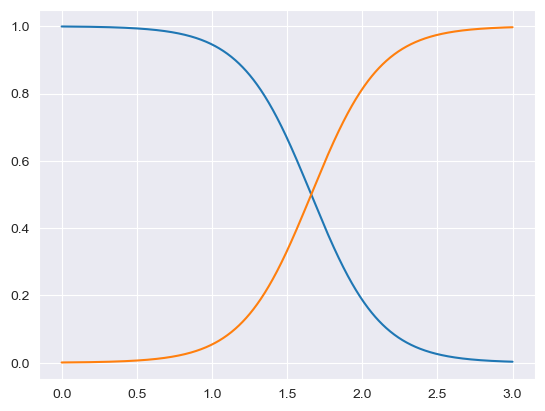

In [77]:
X_train = X[:, 3].reshape(-1, 1)
y_train = (y == 2).astype(np.int8)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_train)
accuracy = accuracy_score(y, y_pred)
print('accuracy: {:.4f}'.format(accuracy))
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_probs = log_reg.predict_proba(X_new)

for i in range(y_probs.shape[1]):
    plt.plot(X_new, y_probs[:, i])
plt.show()


accuracy: 0.3533


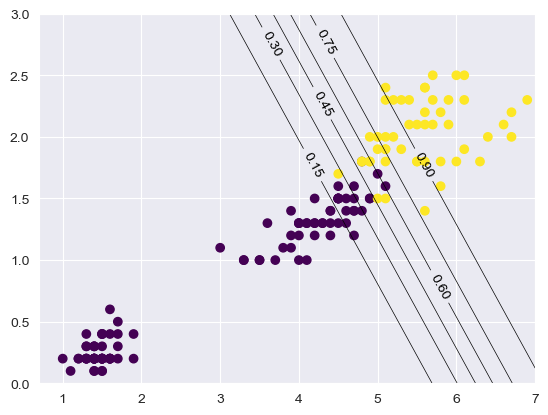

In [96]:
X_train = X[:, (2,3)]
y_train = (y == 2).astype(np.int8)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_train)
accuracy = accuracy_score(y, y_pred)
print('accuracy: {:.4f}'.format(accuracy))
xx, yy = np.meshgrid(np.linspace(3, 7, 100), np.linspace(0, 3, 100))
# X_new = np.vstack([xx.ravel(), yy.ravel()]).T
X_new = np.c_[xx.ravel(), yy.ravel()]
y_probs = log_reg.predict_proba(X_new)
y_probs = y_probs[:,1].reshape(xx.shape)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis')
contour = plt.contour(xx, yy, y_probs, colors='k', linewidths=0.5)
plt.clabel(contour)
plt.show()

In [110]:
### 最新版本softmax,不需要指定multi_class,默认就是softmax,且ovr方式被单独修改为一个类叫OneVsRestClassifier
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

X, y = load_iris(return_X_y=True)
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000)
log_reg.fit(X, y)
y_probs = log_reg.predict_proba(X)
print(y_probs)
# print(np.sum(y_probs, axis=1))

[[9.81689246e-01 1.83107392e-02 1.44683753e-08]
 [9.71552278e-01 2.84476919e-02 3.02549023e-08]
 [9.85354847e-01 1.46451402e-02 1.23586408e-08]
 [9.76159266e-01 2.38406941e-02 3.98164532e-08]
 [9.85297905e-01 1.47020831e-02 1.19767156e-08]
 [9.70297452e-01 2.97024747e-02 7.36795763e-08]
 [9.86803331e-01 1.31966492e-02 2.00177846e-08]
 [9.76266641e-01 2.37333317e-02 2.77062407e-08]
 [9.79718492e-01 2.02814771e-02 3.07587575e-08]
 [9.68970349e-01 3.10296196e-02 3.17482239e-08]
 [9.76373540e-01 2.36264409e-02 1.92793514e-08]
 [9.75279458e-01 2.47204982e-02 4.39568027e-08]
 [9.74414688e-01 2.55852906e-02 2.15533786e-08]
 [9.91917367e-01 8.08262928e-03 3.90538994e-09]
 [9.88124029e-01 1.18759685e-02 2.81808373e-09]
 [9.86689562e-01 1.33104253e-02 1.28201870e-08]
 [9.88029772e-01 1.19702186e-02 9.22169165e-09]
 [9.81435726e-01 1.85642546e-02 1.97473747e-08]
 [9.56363570e-01 4.36363614e-02 6.85885450e-08]
 [9.84024625e-01 1.59753547e-02 2.05729252e-08]
 [9.46518918e-01 5.34809954e-02 8.664916

In [111]:
from sklearn.multiclass import OneVsRestClassifier
ovr = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=1000))
ovr.fit(X, y)
y_probs = ovr.predict_proba(X)
print(y_probs)
print(np.sum(y_probs, axis=1))
print(ovr.predict(X))

[[8.96813456e-01 1.03185472e-01 1.07194623e-06]
 [7.78984138e-01 2.21014550e-01 1.31163851e-06]
 [8.34873009e-01 1.65125977e-01 1.01427196e-06]
 [7.90013297e-01 2.09984797e-01 1.90590562e-06]
 [9.12057221e-01 8.79417044e-02 1.07481744e-06]
 [9.53758162e-01 4.62385676e-02 3.27007792e-06]
 [8.81770123e-01 1.18228158e-01 1.71844775e-06]
 [8.69401485e-01 1.30596982e-01 1.53309809e-06]
 [7.41455184e-01 2.58543221e-01 1.59499666e-06]
 [7.80762436e-01 2.19236248e-01 1.31598647e-06]
 [9.26224090e-01 7.37747160e-02 1.19405214e-06]
 [8.58537109e-01 1.41460689e-01 2.20235473e-06]
 [7.61305000e-01 2.38693956e-01 1.04389682e-06]
 [7.78336603e-01 2.21662864e-01 5.32759504e-07]
 [9.68070443e-01 3.19291820e-02 3.75485353e-07]
 [9.86162793e-01 1.38359354e-02 1.27174614e-06]
 [9.64851432e-01 3.51475630e-02 1.00550592e-06]
 [9.06744582e-01 9.32540354e-02 1.38228449e-06]
 [9.39988505e-01 6.00091165e-02 2.37826864e-06]
 [9.42637670e-01 5.73606799e-02 1.64977221e-06]
 [8.60515777e-01 1.39481849e-01 2.374352

In [113]:
## ovr概率和不一定为1
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=100, n_classes=3, n_informative=5,
                           n_clusters_per_class=1, n_features=10, random_state=42)

# 需要将 y 转成 one-hot 多标签形式
from sklearn.preprocessing import label_binarize
y_multi = label_binarize(y, classes=[0,1,2])

clf = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=1000))
clf.fit(X, y_multi)
proba = clf.predict_proba(X[:1])

print(proba)
print("sum of probs =", proba.sum())


[[0.84364904 0.10594664 0.00753064]]
sum of probs = 0.9571263285155813
